In [5]:
!pip install pandas
!pip install torch
!pip install torchvision


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\zamak\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\zamak\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\zamak\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import numpy as np
import torch

# Hardware Check

In [7]:
!nvidia-smi

Tue Oct 28 06:19:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.97                 Driver Version: 555.97         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   57C    P0             13W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
#check if GPU is available and print device name
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print("Using CPU")

Using CPU


# Dataset 

In [9]:
labels_df = pd.read_csv('labels.csv',names=['lat','lng','label1','label2','label3', 'filename'])

In [10]:
total_rows_len = len(labels_df)
print(f"\nTotal number of rows: {total_rows_len}")
labels_df.head()


Total number of rows: 2178


,lat,lng,label1,label2,label3,filename
0,10.328221,-20.476357,FR II,NaN,NaN,NaN
1,92.109802,-49.431413,typical,NaN,NaN,NaN
2,88.916825,-59.431868,Point Source,NaN,NaN,NaN
3,5.457981,-25.589637,FR II,NaN,NaN,NaN
4,119.417608,-53.396711,FR II,NaN,NaN,NaN


In [11]:

import os

filenames = os.listdir('Data/typ/typ_PNG') + os.listdir('Data/exo/exo_PNG')
print(f"Total number of files: {len(filenames)}")

# Print first 5 filenames
for i in range(5):
    print(filenames[i])

Total number of files: 2108
0.250 -25.084_[0.02238656 0.02238656] deg_(Abell_141_1pln-forPyBDSF.FITS).fits.png
0.316 -24.707_[0.0166409 0.0166409] deg_(Abell_141_1pln-forPyBDSF.FITS).fits.png
0.327 -24.571_[0.02705031 0.02705031] deg_(Abell_141_1pln-forPyBDSF.FITS).fits.png
0.371 -24.554_[0.009 0.009] deg_(Abell_141_1pln-forPyBDSF.FITS).fits.png
0.425 -25.211_[0.02334787 0.02334787] deg_(Abell_141_1pln-forPyBDSF.FITS).fits.png


In [12]:
print(labels_df.dtypes)

lat         float64
lng         float64
label1       object
label2       object
label3       object
filename    float64
dtype: object


In [13]:
for i, filename in enumerate(filenames,start=0):
    coordinates = filename.split('_')[0]
    if coordinates.count(' ') != 1:
        print(f"Skipping filename with unexpected format: {filename}")
        continue
    
    lat, lng = coordinates.split(' ')
    lat, lng = float(lat), float(lng)
   
    label_row = labels_df[(labels_df['lat'].round(3) == lat) & (labels_df['lng'].round(3) == lng)]
    if not label_row.empty:
        labels_df.loc[label_row.index, 'filename'] = filename

C:\Users\zamak\AppData\Local\Temp\ipykernel_17192\110920357.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.250 -25.084_[0.02238656 0.02238656] deg_(Abell_141_1pln-forPyBDSF.FITS).fits.png' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  labels_df.loc[label_row.index, 'filename'] = filename


Skipping filename with unexpected format: .ipynb_checkpoints


## Missed labels

In [14]:
missed_labels_df = labels_df[labels_df['filename'].isnull()]

In [15]:
print(f"\nNumber of missed labels (filename is null): {len(missed_labels_df)}")


Number of missed labels (filename is null): 202


In [16]:
missed_labels_df.head()

,lat,lng,label1,label2,label3,filename
8,351.664270,-40.441765,Should be discarded,NaN,NaN,NaN
10,3.751163,-29.920867,Should be discarded,NaN,NaN,NaN
18,172.646749,-41.932433,Should be discarded,NaN,NaN,NaN
20,97.471185,-56.563903,Should be discarded,NaN,NaN,NaN
23,61.156721,-71.298579,Should be discarded,NaN,NaN,NaN


In [17]:
missed_labels_df['label1'].value_counts()

label1
Should be discarded    130
Point Source            45
FR II                   14
Bent                     8
FR I                     5
Name: count, dtype: int64

In [18]:
missed_labels_df[missed_labels_df['label1'] == 'Point Source'].round(3)

,lat,lng,label1,label2,label3,filename
50,144.600,-76.688,Point Source,Should be discarded,NaN,NaN
487,99.299,-48.271,Point Source,Should be discarded,NaN,NaN
530,49.015,-45.247,Point Source,Should be discarded,NaN,NaN
617,48.944,-45.141,Point Source,Should be discarded,NaN,NaN
754,10.626,-9.358,Point Source,Should be discarded,NaN,NaN
831,61.692,-71.275,Point Source,NaN,Should be discarded,NaN
1146,124.812,-56.955,Point Source,NaN,NaN,NaN
1214,238.526,-76.147,Point Source,Should be discarded,NaN,NaN
1296,92.846,-48.201,Point Source,Should be discarded,NaN,NaN
1323,115.922,-53.675,Point Source,Should be discarded,NaN,NaN


In [19]:
labels_df['label1'].value_counts()

label1
FR II                  683
Point Source           442
FR I                   431
Bent                   428
Should be discarded    130
typical                 24
Exotic                  18
S/Z shaped              17
X-Shaped                 5
Name: count, dtype: int64

In [20]:
labels_df['label2'].value_counts()

label2
Bent                   97
Should be discarded    69
Exotic                 33
S/Z shaped              4
X-Shaped                1
Name: count, dtype: int64

In [21]:
labels_df['label3'].value_counts()

label3
Exotic                 5
Should be discarded    1
Name: count, dtype: int64


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\zamak\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


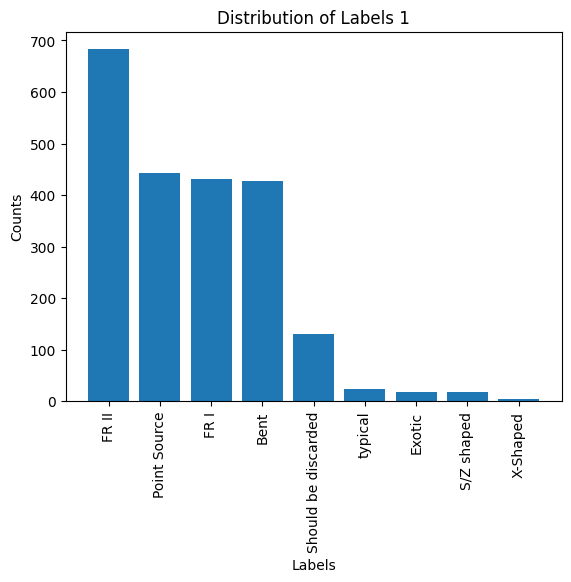

In [22]:
#plot a bar chart of the label1 value counts
!pip install matplotlib

import matplotlib.pyplot as plt

label_counts = labels_df['label1'].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Distribution of Labels 1')
plt.show()

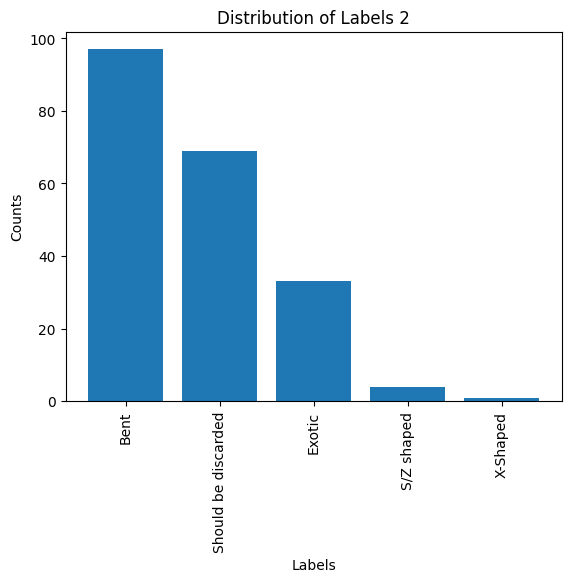

In [23]:
#plot a bar chart of the label1 value counts
import matplotlib.pyplot as plt

label_counts = labels_df['label2'].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Distribution of Labels 2')
plt.show()

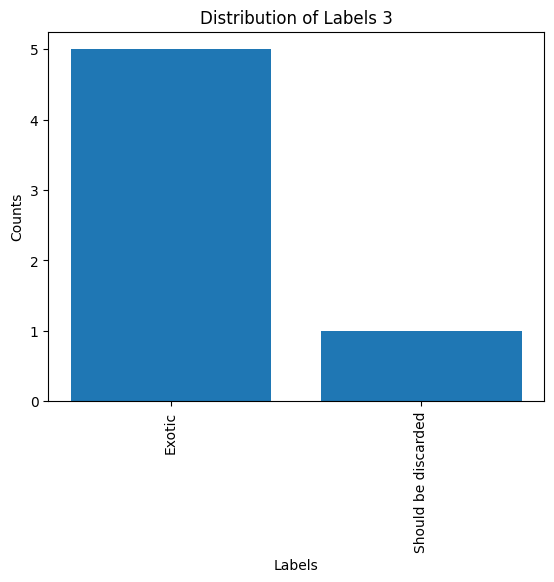

In [24]:
#plot a bar chart of the label1 value counts
import matplotlib.pyplot as plt

label_counts = labels_df['label3'].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Distribution of Labels 3')
plt.show()

In [25]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


In [26]:
# Define augmentation pipeline for training data
train_transform = transforms.Compose([
    transforms.ToTensor(),              # Convert image to PyTorch tensor
    transforms.Resize((224, 224)),      # Resize to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomRotation(15),     # Randomly rotate by +/- 15 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate
])

In [27]:
#combine Data/typ/typ_PNG and Data/exo/exo_PNG into a single dataset with the defined transformations
dataset_typ = ImageFolder(root='Data/typ', transform=train_transform)
dataset_exo = ImageFolder(root='Data/exo', transform=train_transform)
dataset = torch.utils.data.ConcatDataset([dataset_typ, dataset_exo])

dataloader = DataLoader(dataset, batch_size=124, shuffle=True)

# CNN

In [ ]:

vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
for param in vgg16.features.parameters():
    param.requires_grad = False

num_classes = 10 #we will update according to the number of classes we have

vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5), #adjust accordingly to help with overfitting
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5), #adjust accordingly to help with overfitting
    nn.Linear(1024, num_classes)
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
train_losses = []

def train(model, dataloader, criterion, optimizer, device, epochs):
    model.train()
    for epoch in range(epochs):
        
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss = loss.detach().numpy()
            train_losses.append(loss)

        # This part is optional - Evaluation mode
        # After each epoch we validate our model and if we see that the model is nologer learning we update the learning rate 
        model.eval()
        with torch.no_grad():
            val_pred = model(images)
            loss = criterion(val_pred, labels)
            train_losses.append(loss.detach().numpy())
            scheduler.step(loss)
        
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss}")


train(vgg16, dataloader, criterion, optimizer, device, epochs=2)


Epoch [2/2] Loss: 0.0000


In [30]:
# torch.cuda.empty_cache()
# torch.cuda.reset_peak_memory_stats()
# print(torch.cuda.memory_summary(device=None, abbreviated=True))

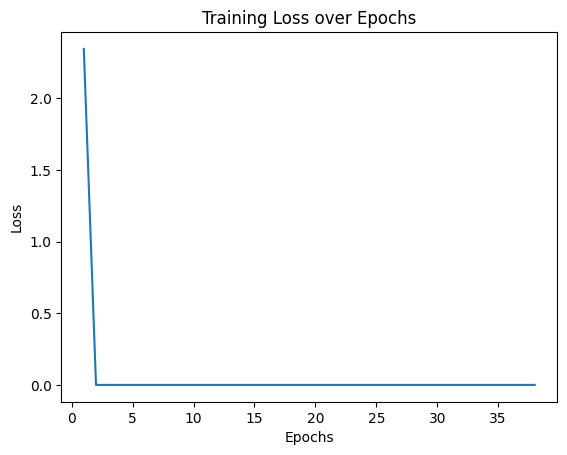

In [31]:
#plot training loss
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()
